In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
ETH = pd.read_csv('ETH_preprocessed.csv', parse_dates = ['Date'], index_col = 'Date')
ETH.head()

,Close,High,Low,Open,Volume,atr,hull_sma,hull_sma_gradient,label,trend_label,Train_label
Date,,,,,,,,,,,
2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984,22.395996,320.884003,NaN,0,3.0,3
2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984,23.433329,320.264109,-0.619893,0,3.0,3
2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992,23.143688,319.677107,-0.587003,1,3.0,1
2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936,22.809865,318.932044,-0.745062,1,3.0,1
2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984,22.620551,318.348707,-0.583338,1,3.0,1


In [3]:
#log returns, differencing
ETH['Log_Close'] = np.log(ETH['Close'] / ETH['Close'].shift(1))
ETH['Log_High'] = np.log(ETH['High'] / ETH['High'].shift(1))
ETH['Log_Low'] = np.log(ETH['Low'] / ETH['Low'].shift(1))
ETH['Log_Open'] = np.log(ETH['Open'] / ETH['Open'].shift(1))
ETH['Log_Volume'] = np.log(ETH['Volume'] / ETH['Volume'].shift(1))
#Relative candlestick patterns
ETH['Body'] = ETH['Close'] - ETH['Open']
ETH['Range'] = ETH['High'] - ETH['Low']
ETH['Upper_Wick'] = ETH['High'] - np.maximum(ETH['Close'], ETH['Open'])
ETH['Lower_Wick'] = np.minimum(ETH['Close'], ETH['Open']) - ETH['Low']
ETH.head()

,Close,High,Low,Open,Volume,atr,hull_sma,hull_sma_gradient,label,trend_label,Train_label,Log_Close,Log_High,Log_Low,Log_Open,Log_Volume,Body,Range,Upper_Wick,Lower_Wick
Date,,,,,,,,,,,,,,,,,,,,
2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984,22.395996,320.884003,NaN,0,3.0,3,NaN,NaN,NaN,NaN,NaN,12.239014,22.395996,8.567993,1.588989
2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984,23.433329,320.264109,-0.619893,0,3.0,3,-0.069790,-0.014474,-0.041609,0.038224,-0.008165,-21.417999,30.175995,4.046997,4.710999
2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992,23.143688,319.677107,-0.587003,1,3.0,1,0.050270,-0.016347,0.012316,-0.071358,-0.050564,16.095001,21.261017,4.772003,0.394012
2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936,22.809865,318.932044,-0.745062,1,3.0,1,-0.021758,-0.000940,0.001076,0.052530,0.650011,-6.782013,20.640015,4.463013,9.394989
2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984,22.620551,318.348707,-0.583338,1,3.0,1,0.028204,0.028607,0.028116,-0.024659,-0.437357,9.691010,21.390015,11.699005,0.000000


In [4]:
#preparing X train and Y train
X = ETH[1:].drop(columns=['Close', 'High', 'Low', 'Open', 'Volume', 'atr', 'hull_sma', 'label', 'hull_sma_gradient', 'trend_label', 'label', 'Train_label'])
Y = ETH['Train_label'][1:]
X.tail(), Y.tail(), X.head(), Y.head()

(            Log_Close  Log_High   Log_Low  Log_Open  Log_Volume        Body  \
 Date                                                                          
 2025-10-15  -0.034012 -0.012089  0.010008 -0.028676   -0.284859 -137.901855   
 2025-10-16  -0.023524 -0.032367 -0.027177 -0.034077   -0.026414  -92.394531   
 2025-10-17  -0.016098 -0.032152 -0.040237 -0.023543    0.155295  -61.818848   
 2025-10-18   0.014965 -0.005921  0.038306 -0.015884   -0.879775   57.336670   
 2025-10-20   0.036570  0.027130  0.025228  0.038647    0.393102   51.208252   
 
                  Range  Upper_Wick  Lower_Wick  
 Date                                            
 2025-10-15  278.694580   88.494629   52.298096  
 2025-10-16  249.994141   92.499268   65.100342  
 2025-10-17  271.946533   56.189209  153.938477  
 2025-10-18  104.979248   36.899414   10.743164  
 2025-10-20  115.330078    0.000000   64.121826  ,
 Date
 2025-10-15    4
 2025-10-16    4
 2025-10-17    4
 2025-10-18    4
 2025-10-20  

In [5]:
#Create pipeline for transformation of features
def prepare_data(df, scaler_type):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df))
    return df_scaled
X_scaled = prepare_data(X, 'minmax')
X_scaled.rename(columns = lambda x: X.columns[x], inplace = True)
X_scaled, X_scaled.shape, Y.shape

(      Log_Close  Log_High   Log_Low  Log_Open  Log_Volume      Body     Range  \
 0      0.612296  0.563129  0.614231  0.750954    0.443293  0.588757  0.019512   
 1      0.765147  0.559991  0.685179  0.610344    0.425812  0.613282  0.013506   
 2      0.673446  0.585800  0.670390  0.769311    0.714662  0.598325  0.013087   
 3      0.737055  0.635295  0.705966  0.670266    0.266336  0.609095  0.013593   
 4      0.782561  0.646318  0.710057  0.741973    0.457513  0.616402  0.014956   
 ...         ...       ...       ...       ...         ...       ...       ...   
 2896   0.657846  0.567124  0.682142  0.665111    0.329212  0.512604  0.186948   
 2897   0.671199  0.533155  0.633217  0.658181    0.435769  0.542355  0.167611   
 2898   0.680653  0.533516  0.616035  0.671698    0.510689  0.562344  0.182402   
 2899   0.720200  0.577456  0.719373  0.681526    0.083926  0.640244  0.069910   
 2900   0.747706  0.632820  0.702167  0.751496    0.608737  0.636238  0.076883   
 
       Upper_W

In [6]:
#manually create windows of 20 as lookback sequence for feature and target
lookback = 10
num_classes = 4
def create_sequences(X, lookback):
    Xs = []
    for i in range(len(X) - lookback):
        Xs.append(X.iloc[i:(i+lookback)])
    return np.array(Xs)
X_seq = create_sequences(X_scaled, lookback)
Y_seq = Y[lookback:] - 1
Y_seq = to_categorical(Y_seq, num_classes=num_classes)
X_seq = X_seq.astype(np.float32)
Y_seq = Y_seq.astype(np.float32)
#Y_seq, 0 is positive inflection, 1 is negative inflection, 2 is uptrend, 3 is downtrend
X_seq.shape, Y_seq.shape

((2891, 10, 9), (2891, 4))

In [7]:
#Baseline CNN model
model = models.Sequential()
#layer 1
model.add(layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(10,9)))
model.add(layers.Conv1D(64, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling1D())
#layer 2
model.add(layers.Conv1D(64, kernel_size=2, activation='relu'))
model.add(layers.Conv1D(64, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling1D())
#layer 3
#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.5))

#GRU
model.add(layers.GRU(64))  
#output layer
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\User\Desktop\fintech-proj\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
#train model
X_train, X_val, Y_train, Y_val = train_test_split(X_seq, Y_seq, test_size=0.2, shuffle=False)
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4131 - loss: 1.1989 - val_accuracy: 0.3713 - val_loss: 1.1328
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4131 - loss: 1.1989 - val_accuracy: 0.3713 - val_loss: 1.1328
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4265 - loss: 1.1732 - val_accuracy: 0.4732 - val_loss: 1.1081
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4265 - loss: 1.1732 - val_accuracy: 0.4732 - val_loss: 1.1081
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4472 - loss: 1.1589 - val_accuracy: 0.4525 - val_loss: 1.1200
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4472 - loss: 1.1589 - val_accuracy: 0.4525 - val_loss: 1.1200
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4654 - loss: 1.1609 - val_accuracy: 0.4439 - val_loss: 1.0834
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4654 - loss: 1.1609 - val_accuracy: 0.44

In [9]:
# --- Serialize model and preprocessing artifacts ---
# This saves the trained Keras model (SavedModel), a fitted MinMaxScaler, and the original label classes
import joblib
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

models_dir = Path('./models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save Keras model in SavedModel format (creates directory)
model.save(models_dir / 'eth_cnn_gru_saved.keras')

# Fit a MinMaxScaler on the original feature DataFrame X (same scaler type used above) and save it
scaler = MinMaxScaler()
scaler.fit(X)
joblib.dump(scaler, models_dir / 'minmax_scaler.joblib')

# Save original label classes so we can map prediction indices back to labels
original_labels = sorted(ETH['Train_label'].dropna().unique())
joblib.dump(original_labels, models_dir / 'original_labels.joblib')

print('Saved model to', models_dir / 'eth_cnn_gru_saved')
print('Saved scaler to', models_dir / 'minmax_scaler.joblib')
print('Saved label classes to', models_dir / 'original_labels.joblib')

Saved model to models\eth_cnn_gru_saved
Saved scaler to models\minmax_scaler.joblib
Saved label classes to models\original_labels.joblib


In [10]:
# --- Example: load saved artifacts (quick smoke test) ---
import joblib
from tensorflow.keras.models import load_model

loaded_model = load_model('./models/eth_cnn_gru_saved.keras')
loaded_scaler = joblib.load('./models/minmax_scaler.joblib')
loaded_labels = joblib.load('./models/original_labels.joblib')

print('Loaded model:', loaded_model)
print('Loaded scaler type:', type(loaded_scaler))
print('Loaded labels:', loaded_labels)

Loaded model: <Sequential name=sequential, built=True>
Loaded scaler type: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Loaded labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


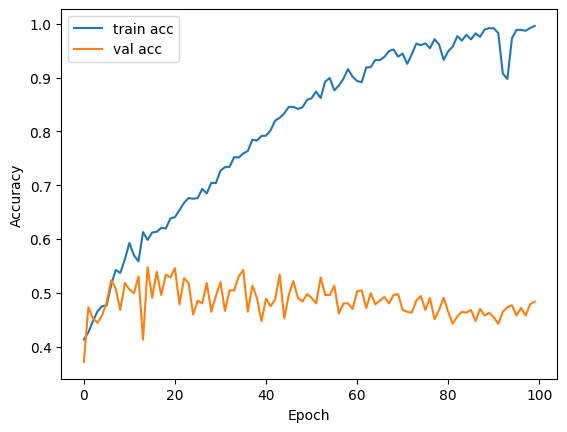

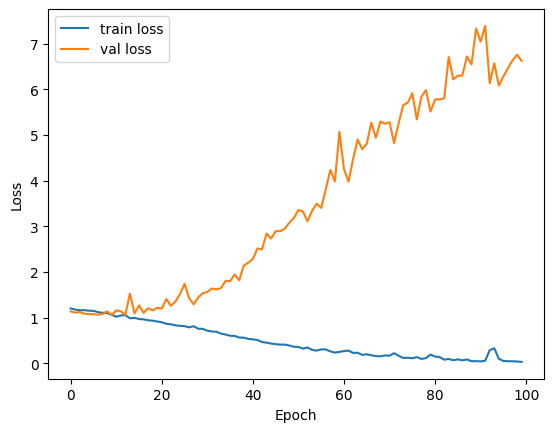

In [11]:
#train validation plot
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


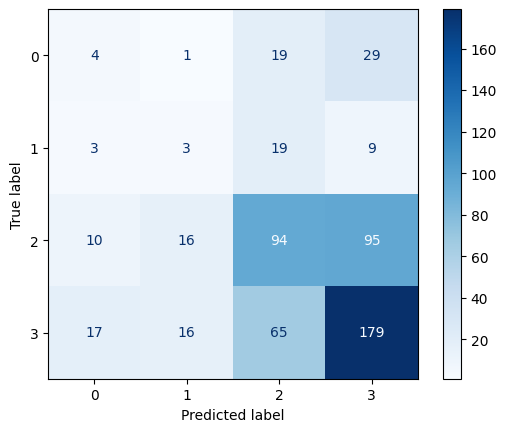

In [12]:
#Confusion matrix
Y_pred = loaded_model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred_classes, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

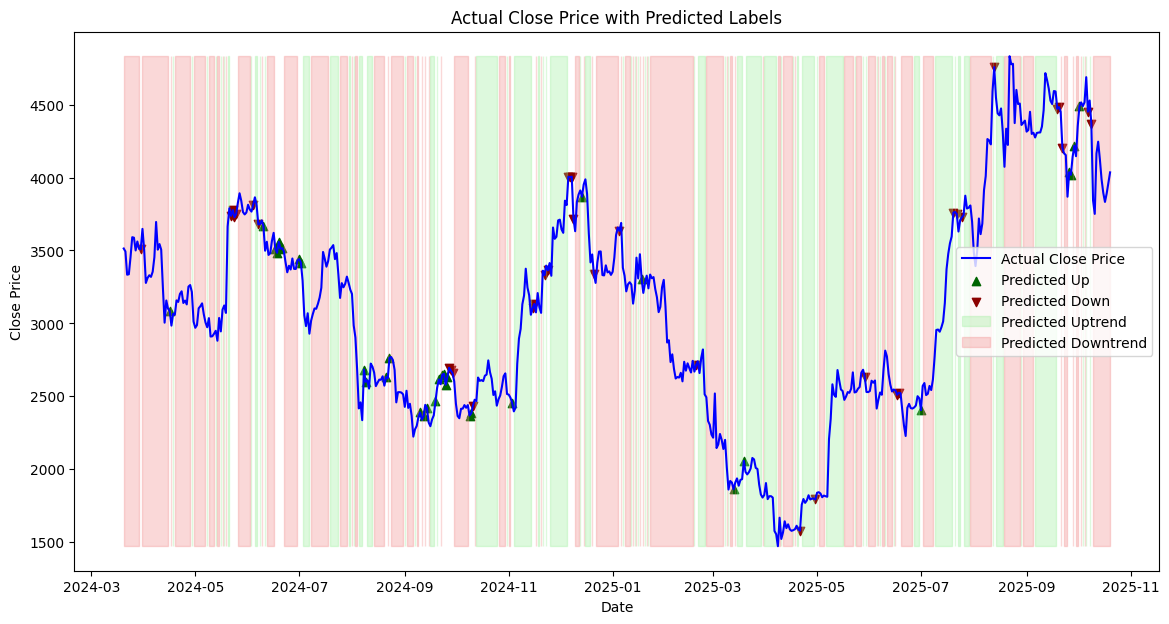

In [13]:
# val_dates, val_close, predicted_labels already defined
val_dates = ETH.index[-len(X_val):]
val_close = ETH['Close'][-len(X_val):]
predicted_labels = np.argmax(Y_pred, axis=1)

plt.figure(figsize=(14,7))
plt.plot(val_dates, val_close, label='Actual Close Price', color='blue')

# Up predictions (0)
up_mask = predicted_labels == 0
plt.scatter(val_dates[up_mask], val_close[up_mask], color='darkgreen', marker='^', label='Predicted Up')

# Down predictions (1)
down_mask = predicted_labels == 1
plt.scatter(val_dates[down_mask], val_close[down_mask], color='darkred', marker='v', label='Predicted Down')

#background shading using fill between on the same plot
plt.fill_between(val_dates, val_close.min(), val_close.max(), where=predicted_labels==2, color='lightgreen', alpha=0.3, label='Predicted Uptrend')
plt.fill_between(val_dates, val_close.min(), val_close.max(), where=predicted_labels==3, color='lightcoral', alpha=0.3, label='Predicted Downtrend')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual Close Price with Predicted Labels')
plt.legend()
plt.show()


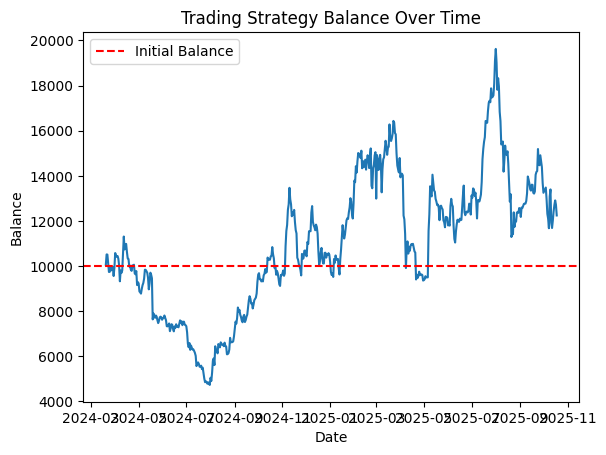

In [14]:
#profits from long and short positions changing positions based on labels, no closing of positions, just switching
initial_balance = 10000
balance = initial_balance
position = 0  # 1 for long, -1 for short, 0 for no position
balance_history = []
for i in range(len(val_close)-1):
    if predicted_labels[i] == 0:  # Predicted Up
        if position != 1:  # Not already long
            position = 1
    elif predicted_labels[i] == 1:  # Predicted Down
        if position != -1:  # Not already short
            position = -1
    elif predicted_labels[i] == 2:  # Predicted Uptrend
        if position != 1:
            position = 1
    elif predicted_labels[i] == 3:  # Predicted Downtrend
        if position != -1:
            position = -1

    # Update balance based on position and price change
    price_change = val_close.iloc[i+1] - val_close.iloc[i]
    balance += position * price_change * (balance / val_close.iloc[i])  # Adjust balance based on leverage

    balance_history.append(balance)
# Plot balance over time
plt.plot(val_dates[:-1], balance_history)
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Trading Strategy Balance Over Time')
plt.axhline(y=initial_balance, color='r', linestyle='--', label='Initial Balance')
plt.legend()
plt.show()



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


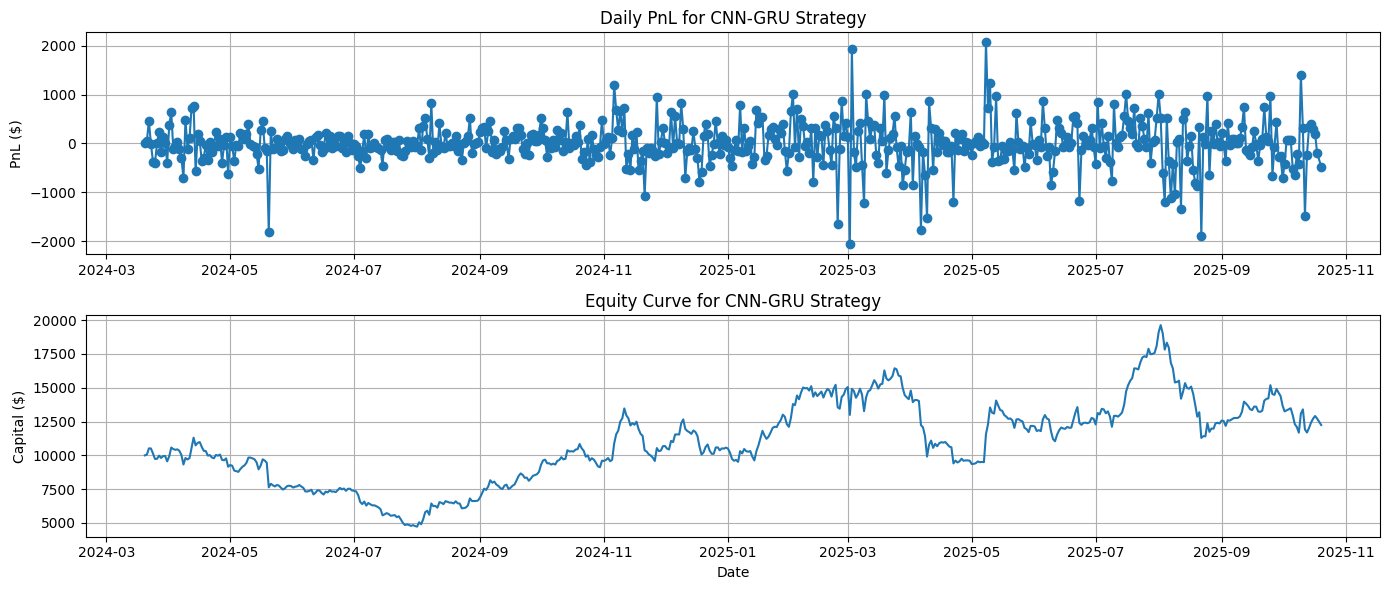

In [15]:
# Generate validation signals directly from the trained CNN-GRU model
val_probabilities = model.predict(X_val)
val_predicted_labels = np.argmax(val_probabilities, axis=1)

# Classes 0/2 indicate long bias, 1/3 short bias
signal_lookup = np.array([1, -1, 1, -1], dtype=np.int8)
validation_signals = signal_lookup[val_predicted_labels]


def backtest_daily_pnl(trading_signals, price_series, initial_capital=10000):
    prices = np.asarray(price_series, dtype=float)
    signals = np.asarray(trading_signals, dtype=float)

    assert len(prices) == len(signals), "Prices and signals must align"
    assert len(prices) > 1

    capital = initial_capital
    equity_curve = [capital]
    pnl_list = [0.0]

    for i in range(len(prices) - 1):
        today_price = prices[i]
        next_price = prices[i + 1]
        signal = signals[i]

        position_size = capital / today_price
        daily_pnl = position_size * (next_price - today_price) * signal

        capital += daily_pnl
        pnl_list.append(daily_pnl)
        equity_curve.append(capital)

    return np.array(pnl_list), np.array(equity_curve)


prices_for_backtest = val_close.iloc[: len(validation_signals)].values
dates_for_backtest = val_dates[: len(validation_signals)]

pnl_trend, equity_curve_trend = backtest_daily_pnl(
    validation_signals,
    prices_for_backtest,
    initial_capital=10000,
)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(dates_for_backtest, pnl_trend, marker='o')
plt.title("Daily PnL for CNN-GRU Strategy")
plt.ylabel("PnL ($)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dates_for_backtest, equity_curve_trend)
plt.title("Equity Curve for CNN-GRU Strategy")
plt.ylabel("Capital ($)")
plt.xlabel("Date")
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm.auto import tqdm

c:\Users\User\Desktop\fintech-proj\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features_arr, target_arr, n_back=30):
        self.all_data = []
        self.n_back = n_back
        for time_step in tqdm(range(n_back, len(features_arr))):
            # X is the sequence of features up to time_step-1
            X_sequence = features_arr[time_step-n_back:time_step]
            # y is the target label at time_step
            y_label = target_arr[time_step]
            self.all_data.append((X_sequence, y_label))

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        # Unpack the stored tuple into X (feature sequence) and y (target label)
        X, y = self.all_data[idx]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long) # Target label should be long for CrossEntropyLoss
        return X, y

class PredictionModel(nn.Module):
    """
    LSTM for trend prediction
    """
    def __init__(self, input_dim=X_seq.shape[-1], hidden_dim=32, num_layers=2, output_dim=num_classes):
        super().__init__()
        self.current_seq_ix = None
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out1, _ = self.lstm1(x)  # out: (batch, seq_len, hidden_dim)
        out2 = self.fc1(out1[:, -1, :]) #out2: (batch, num_classes)
        return out2

print(f"Number of output classes (num_classes): {num_classes}")

# Reuse the same log-return preprocessing and deterministic split as the CNN-GRU pipeline
train_class_ids = np.argmax(Y_train, axis=1)
val_class_ids = np.argmax(Y_val, axis=1)

train_dataset_trend = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(train_class_ids, dtype=torch.long),
)
val_dataset_trend = torch.utils.data.TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(val_class_ids, dtype=torch.long),
)

BATCH_SIZE = 64
train_loader_trend = DataLoader(train_dataset_trend, batch_size=BATCH_SIZE, shuffle=False)
val_loader_trend = DataLoader(val_dataset_trend, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader_trend)}, Validation batches: {len(val_loader_trend)}")

Number of output classes (num_classes): 4
Train batches: 37, Validation batches: 10


100%|██████████| 37/37 [00:00<00:00, 58.21it/s]


Epoch 1/10, Loss: 49.340105175971985


100%|██████████| 37/37 [00:00<00:00, 91.35it/s]


Epoch 2/10, Loss: 43.78363651037216


100%|██████████| 37/37 [00:00<00:00, 81.58it/s]


Epoch 3/10, Loss: 43.41425538063049


100%|██████████| 37/37 [00:00<00:00, 89.31it/s]


Epoch 4/10, Loss: 43.361681044101715


100%|██████████| 37/37 [00:00<00:00, 89.16it/s]


Epoch 5/10, Loss: 43.34441763162613


100%|██████████| 37/37 [00:00<00:00, 89.89it/s]


Epoch 6/10, Loss: 43.33234113454819


100%|██████████| 37/37 [00:00<00:00, 73.95it/s]


Epoch 7/10, Loss: 43.32631939649582


100%|██████████| 37/37 [00:00<00:00, 91.26it/s]


Epoch 8/10, Loss: 43.321507930755615


100%|██████████| 37/37 [00:00<00:00, 87.10it/s]


Epoch 9/10, Loss: 43.315218687057495


100%|██████████| 37/37 [00:00<00:00, 89.50it/s]



Epoch 10/10, Loss: 43.30545198917389


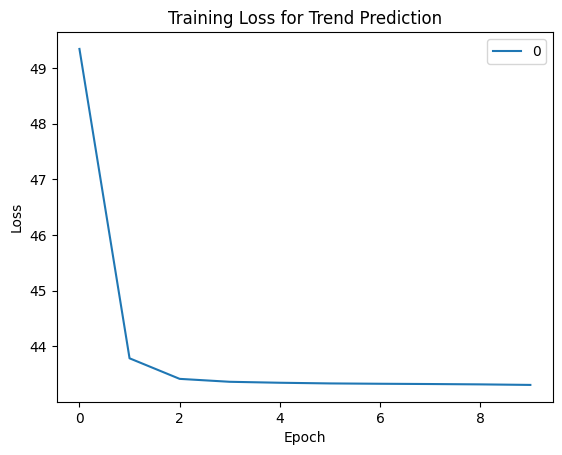

In [21]:
EPOCHS = 10
model_trend = PredictionModel(output_dim=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_trend = nn.CrossEntropyLoss() # Use CrossEntropyLoss for classification
optimizer_trend = torch.optim.Adam(model_trend.parameters(), lr=1e-3)
loss_history_trend = []
model_trend.to(device)

for epoch in range(EPOCHS):
    model_trend.train()
    total_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader_trend)):
        inputs, targets = inputs.to(device), targets.to(device)

        preds = model_trend(inputs)
        loss = criterion_trend(preds, targets) # targets are already torch.long

        optimizer_trend.zero_grad()
        loss.backward()
        optimizer_trend.step()
        total_loss += loss.item()

    loss_history_trend.append(total_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss}")

plot_df_trend = pd.DataFrame(loss_history_trend)
plot_df_trend.plot(title="Training Loss for Trend Prediction")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

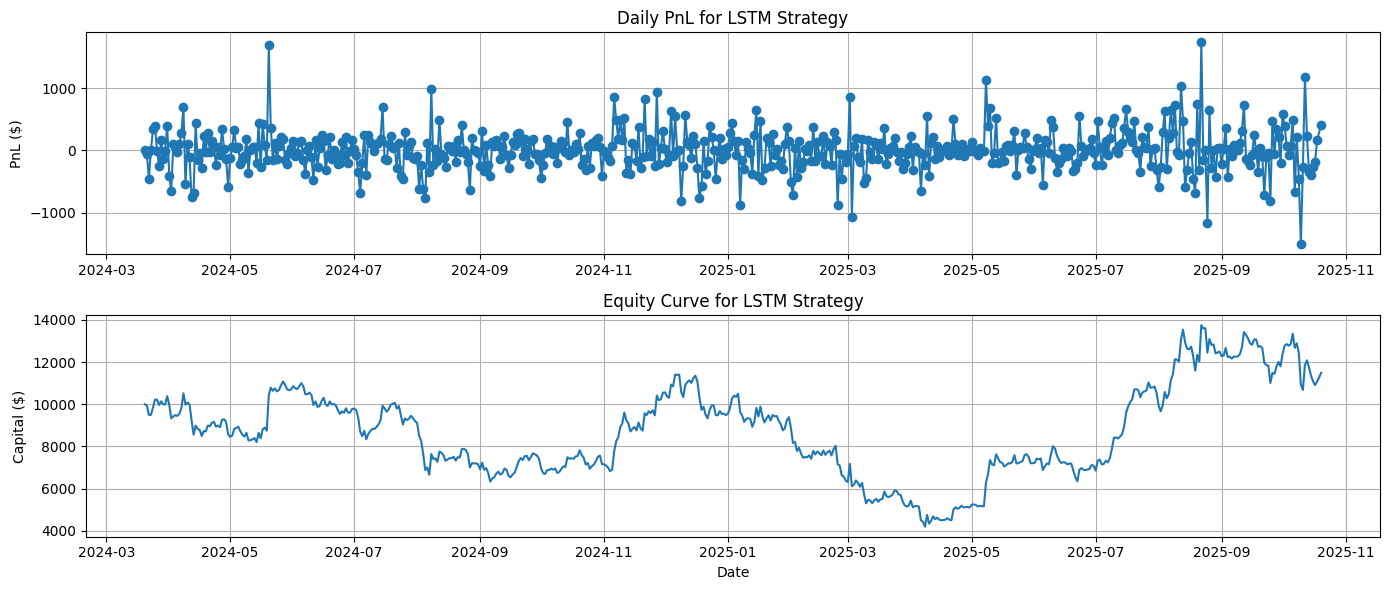

In [22]:
# Generate validation signals from the PyTorch LSTM model
model_trend.eval()
lstm_logits = []
with torch.no_grad():
    for batch_inputs, _ in val_loader_trend:
        batch_inputs = batch_inputs.to(device)
        batch_logits = model_trend(batch_inputs)
        lstm_logits.append(batch_logits.cpu().numpy())

lstm_outputs = np.vstack(lstm_logits)
lstm_predicted_labels = np.argmax(lstm_outputs, axis=1)

# Classes 0/2 indicate long bias, 1/3 short bias
signal_lookup = np.array([1, -1, 1, -1], dtype=np.int8)
validation_signals = signal_lookup[lstm_predicted_labels]


def backtest_daily_pnl(trading_signals, price_series, initial_capital=10000):
    prices = np.asarray(price_series, dtype=float)
    signals = np.asarray(trading_signals, dtype=float)

    assert len(prices) == len(signals), "Prices and signals must align"
    assert len(prices) > 1

    capital = initial_capital
    equity_curve = [capital]
    pnl_list = [0.0]

    for i in range(len(prices) - 1):
        today_price = prices[i]
        next_price = prices[i + 1]
        signal = signals[i]

        position_size = capital / today_price
        daily_pnl = position_size * (next_price - today_price) * signal

        capital += daily_pnl
        pnl_list.append(daily_pnl)
        equity_curve.append(capital)

    return np.array(pnl_list), np.array(equity_curve)


prices_for_backtest = val_close.iloc[: len(validation_signals)].values
dates_for_backtest = val_dates[: len(validation_signals)]

pnl_trend, equity_curve_trend = backtest_daily_pnl(
    validation_signals,
    prices_for_backtest,
    initial_capital=10000,
)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(dates_for_backtest, pnl_trend, marker='o')
plt.title("Daily PnL for LSTM Strategy")
plt.ylabel("PnL ($)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dates_for_backtest, equity_curve_trend)
plt.title("Equity Curve for LSTM Strategy")
plt.ylabel("Capital ($)")
plt.xlabel("Date")
plt.grid(True)

plt.tight_layout()
plt.show()